In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
import pickle
from sklearn.model_selection import train_test_split
import datetime
import os
import subprocess
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
mkt_df = pd.read_excel("ICICIBANK - Modified.xlsx")

In [3]:
mkt_df['Date'] = pd.to_datetime(mkt_df['Date']).astype('int64')

In [4]:
mkt_df.set_index('Date').head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1025481600000000000,25.454500,25.818199,24.818199,25.127300,6.023036,2047540.0
1025568000000000000,26.727301,27.636400,25.236401,26.745399,6.410896,5546354.0
1025654400000000000,28.181801,28.181801,26.645500,28.090900,6.733414,5745267.0
1025740800000000000,27.090900,28.799999,27.036400,27.390900,6.565624,3896602.0
1025827200000000000,27.881800,27.863600,26.945400,27.672701,6.633172,3261038.0


In [5]:
mkt_df = mkt_df.dropna()

In [6]:
def normalizeY(ydf):
    ydf = (ydf + 1) / 2
    return ydf

In [7]:
mkt_df.shape

(4054, 7)

# Train and Test

In [8]:
train = mkt_df[0:3500]
test = mkt_df[3501:4093]

In [9]:
train.columns
print(train[:5],test[:5])

                  Date       Open       High        Low      Close  Adj Close  \
0  1025481600000000000  25.454500  25.818199  24.818199  25.127300   6.023036   
1  1025568000000000000  26.727301  27.636400  25.236401  26.745399   6.410896   
2  1025654400000000000  28.181801  28.181801  26.645500  28.090900   6.733414   
3  1025740800000000000  27.090900  28.799999  27.036400  27.390900   6.565624   
4  1025827200000000000  27.881800  27.863600  26.945400  27.672701   6.633172   

      Volume  
0  2047540.0  
1  5546354.0  
2  5745267.0  
3  3896602.0  
4  3261038.0                        Date        Open        High         Low       Close  \
3575  1477440000000000000  252.182007  258.591003  251.817993  253.091003   
3576  1477526400000000000  256.364014  259.091003  250.000000  258.454987   
3577  1477612800000000000  254.044998  256.817993  250.500000  251.682007   
3578  1477958400000000000  245.455002  254.317993  249.544998  250.317993   
3579  1478044800000000000  247.272995 

# X-Y Split

In [10]:
x_train = train[['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_train = train[['Open']]
x_test = test[['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_test = test[['Open']]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3500, 6) (3500, 1) (553, 6) (553, 1)


# MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))


In [12]:
X_train = scaler.fit_transform(x_train)
Y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(x_test)
Y_test = scaler.fit_transform(y_test)

# Shapes

In [13]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3500, 6) (3500, 1) (553, 6) (553, 1)


In [14]:
print(Y_train)

[[0.01580476]
 [0.01968687]
 [0.02412317]
 ...
 [0.70414503]
 [0.71218799]
 [0.74005327]]


# Model - ANN


In [15]:
import tensorflow as tf
import keras as k

Using TensorFlow backend.


In [16]:
def build_model(lre):
    model = k.Sequential()
    model.add(k.layers.Dense(units=128, activation='relu',input_dim = 6))
    model.add(k.layers.Dense(units = 1024, activation = 'relu'))
    model.add(k.layers.Dense(units = 2058, activation = 'relu'))
    model.add(k.layers.Dense(units = 1024, activation = 'sigmoid'))
    model.add(k.layers.Dense(units = 1, activation = 'linear'))
    adam_o = k.optimizers.Adamax(lr=lre)
    model.compile(optimizer = adam_o, loss = 'mean_squared_error', metrics=['mae'])
    model.summary()
    return model

In [17]:
model = build_model(0.001)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_3 (Dense)              (None, 2058)              2109450   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2108416   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 4,351,883
Trainable params: 4,351,883
Non-trainable params: 0
_________________________________________________________________


In [18]:
tb = k.callbacks.EarlyStopping(monitor='val_loss',  patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train,Y_train,batch_size=200000,epochs=40,verbose = 1, validation_data=(X_test,Y_test), callbacks=[tb])

Train on 3500 samples, validate on 553 samples
Epoch 1/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0704 - mae: 0.2110 - val_loss: 0.2890 - val_mae: 0.4831
Epoch 2/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.2730 - mae: 0.4632 - val_loss: 0.0433 - val_mae: 0.1722
Epoch 3/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0452 - mae: 0.1842 - val_loss: 0.0911 - val_mae: 0.3004
Epoch 4/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0743 - mae: 0.2696 - val_loss: 0.1584 - val_mae: 0.3974
Epoch 5/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.1322 - mae: 0.3622 - val_loss: 0.0667 - val_mae: 0.2552
Epoch 6/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0559 - mae: 0.2317 - val_loss: 0.0116 - val_mae: 0.0910
Epoch 7/40
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0107 - mae: 0.0788 - val_loss: 0.0211 - val_mae: 0.1176
Epoch 8/40
3500

In [19]:
pred = model.predict(X_test)

# Plotting Results for Test

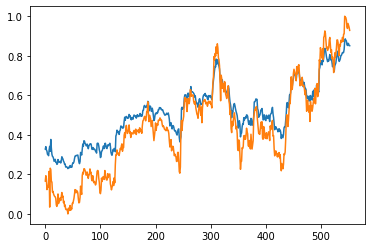

In [20]:
plt.plot(pred)
plt.plot(Y_test)
plt.show()

In [21]:
def MAE(predictions, actual):
    abs_err = [abs(prediction - actualVal) for prediction, actualVal in zip(predictions,actual)]
    mae = sum(abs_err)/len(actual)
    print("MAE =" , mae)
    return mae

def rmse(predictions, targets):
    return print("RMSE =", np.sqrt(((predictions - targets) ** 2).mean()))

In [22]:
MAE(pred,Y_test)
rmse(pred, Y_test)

MAE = [0.09100731]
RMSE = 0.10748339538972922


# Validation


In [23]:
valid_data = pd.read_csv("valid_set_modified1.csv")

In [24]:
def Preprocessing(df):
    df['Date'] = pd.to_datetime(df['Date']).astype('int64')
    df.set_index('Date').head()
    df = df.dropna()
    df.shape
    return(df)

In [25]:
Valid_data = Preprocessing(valid_data)

In [26]:
x_valid = Valid_data[['Date', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y_vaild = Valid_data[['Open']]

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_valid = scaler.fit_transform(x_valid)
Y_valid = scaler.fit_transform(y_vaild)

In [28]:
print(X_valid.shape,Y_valid.shape)

(22, 6) (22, 1)


In [29]:
pred_valid = model.predict(X_valid)
pred_valid.shape

(22, 1)

# Plotting Results for Test

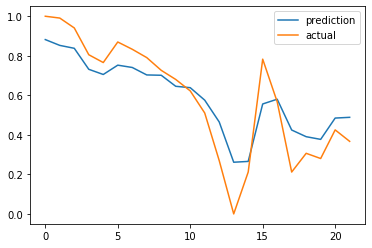

In [30]:
plt.plot(pred_valid,  label='prediction' )
plt.plot(Y_valid,  label='actual')
plt.legend(loc='upper right')
plt.show()

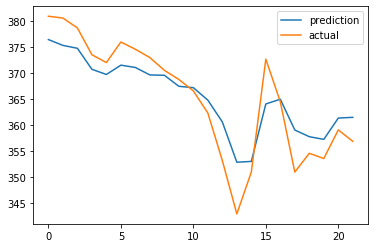

In [31]:
plt.plot(scaler.inverse_transform(np.array(pred_valid).reshape(-1, 1)),label='prediction')
plt.plot(scaler.inverse_transform(np.array(Y_valid).reshape(-1, 1)),label='actual')
plt.legend(loc='upper right')
plt.show()

In [32]:
MAE(pred_valid,Y_valid)
rmse(pred_valid,Y_valid)

MAE = [0.10257239]
RMSE = 0.12246883448386295
